<a href="https://colab.research.google.com/github/ARAVIND2017/gncipl-internship/blob/main/Customer%20Segmentation%20for%20a%20Retail%20Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install extras (only run if packages missing)
!pip install --quiet umap-learn

# Imports and reproducibility
import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
sns.set(style="whitegrid")


In [2]:
from google.colab import files
uploaded = files.upload()  # choose Mall_Customers.csv

# load
df = pd.read_csv('Mall_Customers.csv')
print("Shape:", df.shape)
df.head()


Saving Mall_Customers.csv to Mall_Customers (1).csv
Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Basic info
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

# Drop duplicates (if any)
df = df.drop_duplicates().reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Missing values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Duplicates: 0


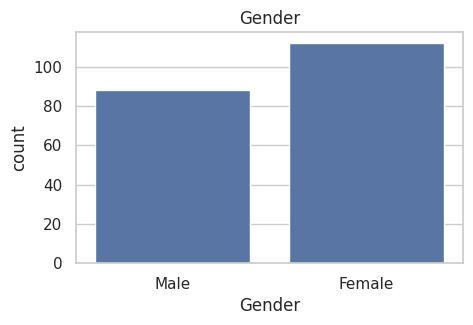

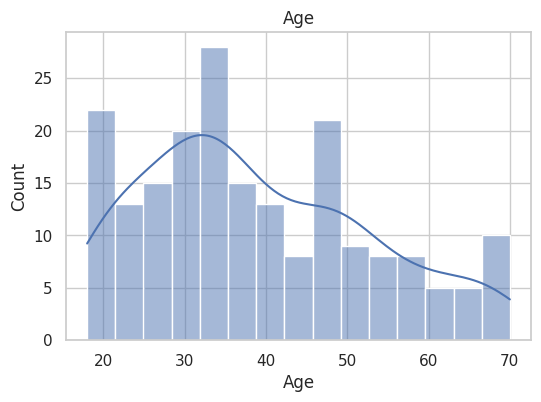

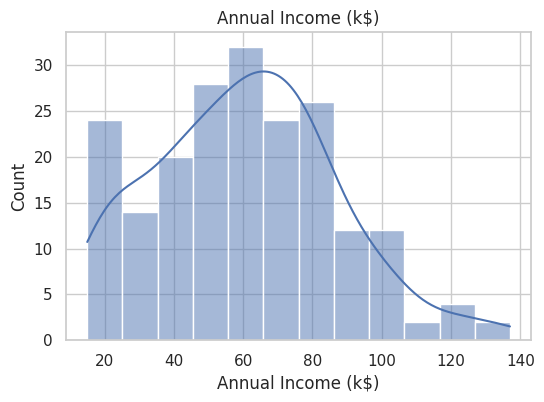

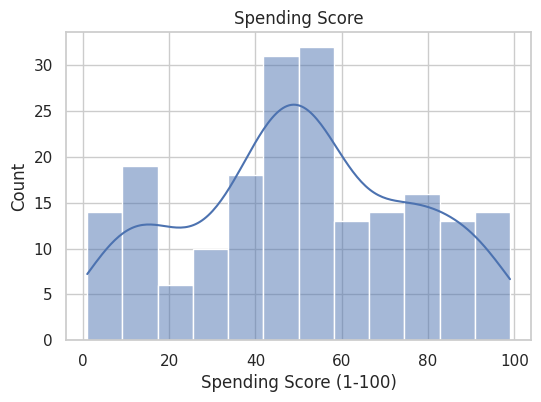

In [4]:
# Gender count
plt.figure(figsize=(5,3)); sns.countplot(x='Gender', data=df); plt.title('Gender'); plt.show()
# Age histogram
plt.figure(figsize=(6,4)); sns.histplot(df['Age'], bins=15, kde=True); plt.title('Age'); plt.show()
# Income histogram
plt.figure(figsize=(6,4)); sns.histplot(df['Annual Income (k$)'], bins=12, kde=True); plt.title('Annual Income (k$)'); plt.show()
# Spending histogram
plt.figure(figsize=(6,4)); sns.histplot(df['Spending Score (1-100)'], bins=12, kde=True); plt.title('Spending Score'); plt.show()


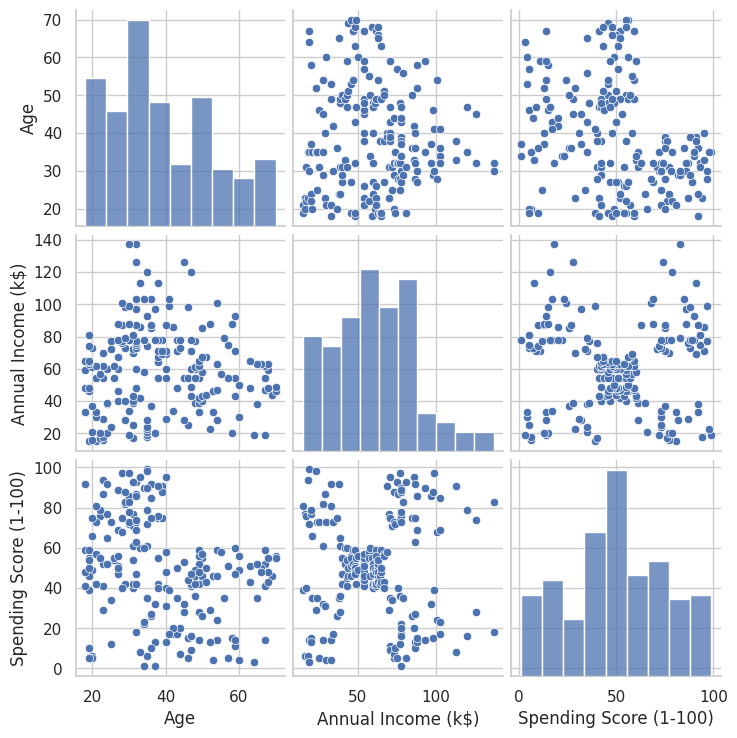

In [5]:
# Pairplot for three numeric features (small sample to speed up)
sns.pairplot(df[['Age','Annual Income (k$)','Spending Score (1-100)']]); plt.show()


In [6]:
df_proc = df.copy()

# Encode Gender
if 'Gender' in df_proc.columns:
    df_proc['Gender_enc'] = LabelEncoder().fit_transform(df_proc['Gender'].astype(str))

# Binning examples (for profiling and optional clustering)
df_proc['Age_group'] = pd.cut(df_proc['Age'], bins=[15,25,35,50,70], labels=['16-25','26-35','36-50','51+'])
df_proc['Income_bin'] = pd.qcut(df_proc['Annual Income (k$)'], q=4, labels=['Low','Medium','High','Very High'])
df_proc['Spend_bin'] = pd.qcut(df_proc['Spending Score (1-100)'], q=4, labels=['Low','Med','High','Very High'])

# Quick view
df_proc.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Gender_enc,Age_group,Income_bin,Spend_bin
0,1,Male,19,15,39,1,16-25,Low,Med
1,2,Male,21,15,81,1,16-25,Low,Very High
2,3,Female,20,16,6,0,16-25,Low,Low
3,4,Female,23,16,77,0,16-25,Low,Very High
4,5,Female,31,17,40,0,26-35,Low,Med


In [9]:
# 2D features (simple & visually attractive)
feat_2d = ['Annual Income (k$)', 'Spending Score (1-100)']

# Advanced features
feat_adv = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
if 'Gender_enc' in df_proc.columns:
    feat_adv.append('Gender_enc')

# Preprocessing pipelines
num_transformer = Pipeline([('scaler', StandardScaler())])

preproc_2d = ColumnTransformer([('num', num_transformer, feat_2d)])
preproc_adv = ColumnTransformer([('num', num_transformer, feat_adv)])


Explained variance (2 comp): 0.599


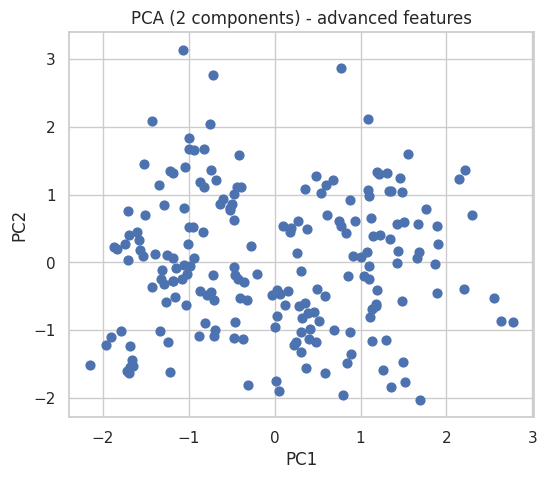

In [10]:
X_adv = df_proc[feat_adv].fillna(df_proc[feat_adv].median())
X_adv_scaled = preproc_adv.fit_transform(df_proc)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
pc = pca.fit_transform(X_adv_scaled)
print("Explained variance (2 comp):", pca.explained_variance_ratio_.sum().round(3))

plt.figure(figsize=(6,5)); plt.scatter(pc[:,0], pc[:,1], s=40)
plt.title('PCA (2 components) - advanced features'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()


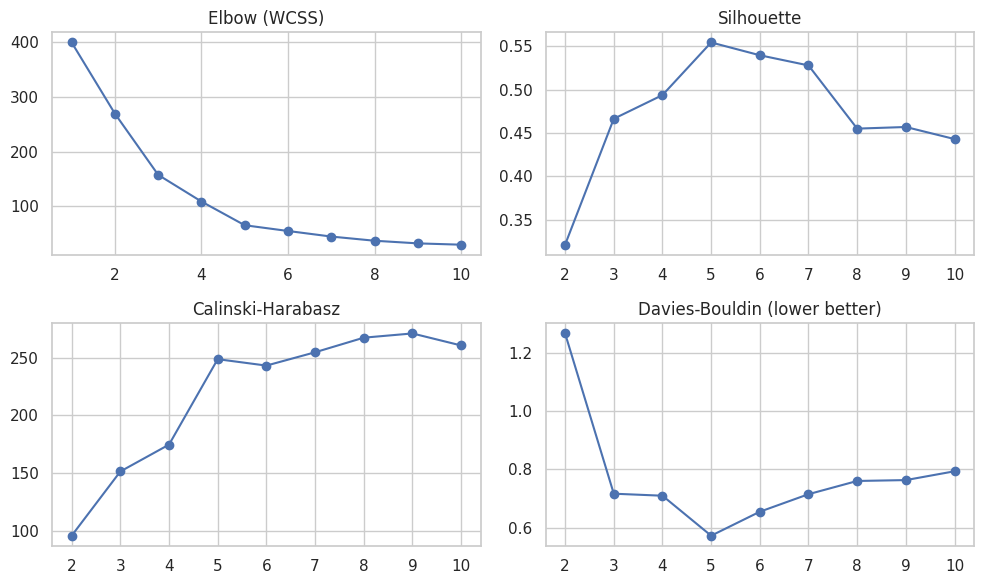

Best k by silhouette: 5 score: 0.5547


In [11]:
# Use 2D scaled data for clarity in WCSS/elbow
X_2d = preproc_2d.fit_transform(df_proc)

wcss = []
sil_scores = []
ch_scores = []
db_scores = []
K = range(2,11)  # silhouette needs k>=2

for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_2d)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(X_2d, labels))
    ch_scores.append(calinski_harabasz_score(X_2d, labels))
    db_scores.append(davies_bouldin_score(X_2d, labels))

# Plot metrics
plt.figure(figsize=(10,6))
plt.subplot(2,2,1); plt.plot(range(1,11), [KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10).fit(X_2d).inertia_ for k in range(1,11)], marker='o'); plt.title('Elbow (WCSS)')
plt.subplot(2,2,2); plt.plot(K, sil_scores, marker='o'); plt.title('Silhouette')
plt.subplot(2,2,3); plt.plot(K, ch_scores, marker='o'); plt.title('Calinski-Harabasz')
plt.subplot(2,2,4); plt.plot(K, db_scores, marker='o'); plt.title('Davies-Bouldin (lower better)')
plt.tight_layout(); plt.show()

# Print best by silhouette:
best_k = K[np.argmax(sil_scores)]
print("Best k by silhouette:", best_k, "score:", max(sil_scores).round(4))


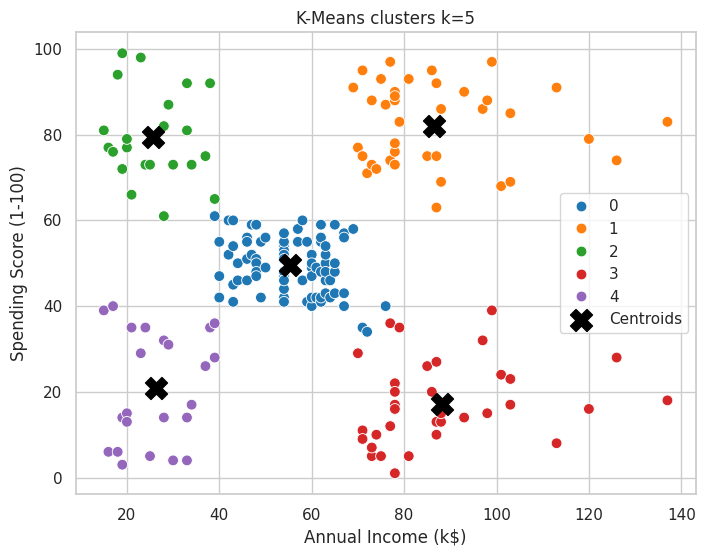

In [12]:
FINAL_K = 5  # set according to above analysis
kmeans = KMeans(n_clusters=FINAL_K, random_state=RANDOM_STATE, n_init=20)
labels = kmeans.fit_predict(X_2d)
df_proc['KMeans_cluster'] = labels

# Plot clusters in original scale (2D)
X_orig = df_proc[feat_2d].values
centers_orig = preproc_2d.named_transformers_['num'].named_steps['scaler'].inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_orig[:,0], y=X_orig[:,1], hue=labels, palette='tab10', s=60, legend='full')
plt.scatter(centers_orig[:,0], centers_orig[:,1], s=250, marker='X', c='black', label='Centroids')
plt.title(f'K-Means clusters k={FINAL_K}'); plt.xlabel(feat_2d[0]); plt.ylabel(feat_2d[1]); plt.legend(); plt.show()


In [13]:
# counts
print("Cluster sizes:")
display(df_proc['KMeans_cluster'].value_counts().sort_index())

# profile: means per cluster (original scale)
profile = df_proc.groupby('KMeans_cluster')[feat_2d + ['Age']].mean().round(2)
display(profile)

# categorical distributions
if 'Gender' in df_proc.columns:
    display(pd.crosstab(df_proc['KMeans_cluster'], df_proc['Gender'], normalize='index').round(2))

# descriptive labels suggestion:
profile['label_suggestion'] = [
    'Low Income, Low Spend',
    'Moderate Income, High Spend',
    'High Income, Low Spend',
    'High Income, High Spend',
    'Low Income, High Spend'
][:profile.shape[0]]
display(profile)


Cluster sizes:


,count
KMeans_cluster,
0,81
1,39
2,22
3,35
4,23


,Annual Income (k$),Spending Score (1-100),Age
KMeans_cluster,,,
0,55.30,49.52,42.72
1,86.54,82.13,32.69
2,25.73,79.36,25.27
3,88.20,17.11,41.11
4,26.30,20.91,45.22


Gender,Female,Male
KMeans_cluster,,
0,0.59,0.41
1,0.54,0.46
2,0.59,0.41
3,0.46,0.54
4,0.61,0.39


,Annual Income (k$),Spending Score (1-100),Age,label_suggestion
KMeans_cluster,,,,
0,55.30,49.52,42.72,"Low Income, Low Spend"
1,86.54,82.13,32.69,"Moderate Income, High Spend"
2,25.73,79.36,25.27,"High Income, Low Spend"
3,88.20,17.11,41.11,"High Income, High Spend"
4,26.30,20.91,45.22,"Low Income, High Spend"


In [14]:
gmm = GaussianMixture(n_components=FINAL_K, random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(X_2d)
df_proc['GMM_cluster'] = gmm_labels
print("Silhouette KMeans:", silhouette_score(X_2d, labels).round(4))
print("Silhouette GMM:", silhouette_score(X_2d, gmm_labels).round(4))


Silhouette KMeans: 0.5547
Silhouette GMM: 0.5537


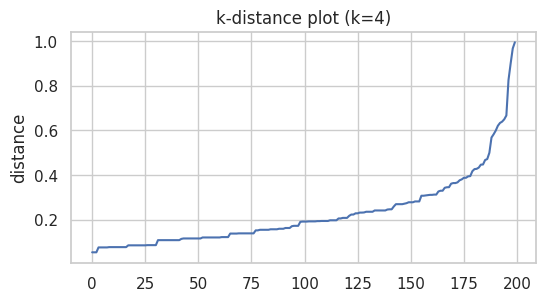

DBSCAN clusters (unique labels): [-1  0  1  2  3  4  5  6  7]
Silhouette (ignoring noise): 0.5197


In [19]:
# k-distance plot for eps selection (k = min_samples)
neighbors = NearestNeighbors(n_neighbors=4)  # min_samples typical ~4
neighbors_fit = neighbors.fit(X_2d)
distances, indices = neighbors_fit.kneighbors(X_2d)
distances = np.sort(distances[:, -1])
plt.figure(figsize=(6,3)); plt.plot(distances); plt.title('k-distance plot (k=4)'); plt.ylabel('distance'); plt.show()

# choose eps visually then:
db = DBSCAN(eps=0.3, min_samples=4)  # adjust eps
db_labels = db.fit_predict(X_2d)
df_proc['DBSCAN_cluster'] = db_labels
print("DBSCAN clusters (unique labels):", np.unique(db_labels))

# Filter out noise points before calculating silhouette score
non_noise_indices = db_labels != -1
if non_noise_indices.sum() > 1:
    print("Silhouette (ignoring noise):", silhouette_score(X_2d[non_noise_indices], db_labels[non_noise_indices]).round(4))
else:
    print("Silhouette (ignoring noise): N/A (not enough non-noise points)")

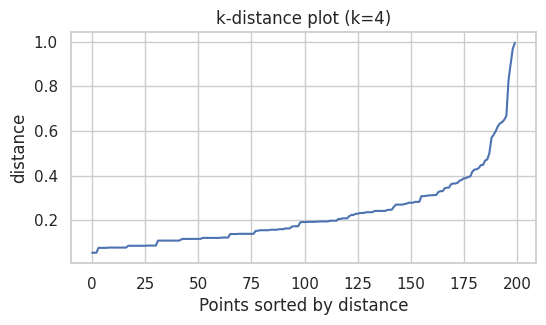

DBSCAN clusters (unique labels): [0]
Silhouette: N/A (found only 1 cluster(s) without noise)


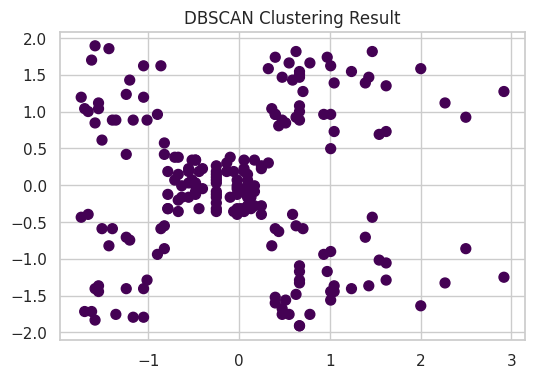

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: k-distance plot for eps selection
neighbors = NearestNeighbors(n_neighbors=4)  # min_samples typical ~4
neighbors_fit = neighbors.fit(X_2d)
distances, indices = neighbors_fit.kneighbors(X_2d)
distances = np.sort(distances[:, -1])
plt.figure(figsize=(6, 3))
plt.plot(distances)
plt.title('k-distance plot (k=4)')
plt.ylabel('distance')
plt.xlabel('Points sorted by distance')
plt.show()

# Step 2: Run DBSCAN with chosen eps and min_samples
db = DBSCAN(eps=0.8, min_samples=4)  # increased eps from 0.6 to 0.8
db_labels = db.fit_predict(X_2d)
df_proc['DBSCAN_cluster'] = db_labels

print("DBSCAN clusters (unique labels):", np.unique(db_labels))

# Step 3: Filter out noise points before silhouette calculation
non_noise_indices = db_labels != -1
unique_labels = np.unique(db_labels[non_noise_indices])

if len(unique_labels) >= 2:
    score = silhouette_score(X_2d[non_noise_indices], db_labels[non_noise_indices]).round(4)
    print(f"Silhouette (ignoring noise): {score}")
else:
    print(f"Silhouette: N/A (found only {len(unique_labels)} cluster(s) without noise)")

# Step 4: Plot clusters
plt.figure(figsize=(6, 4))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=db_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering Result')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


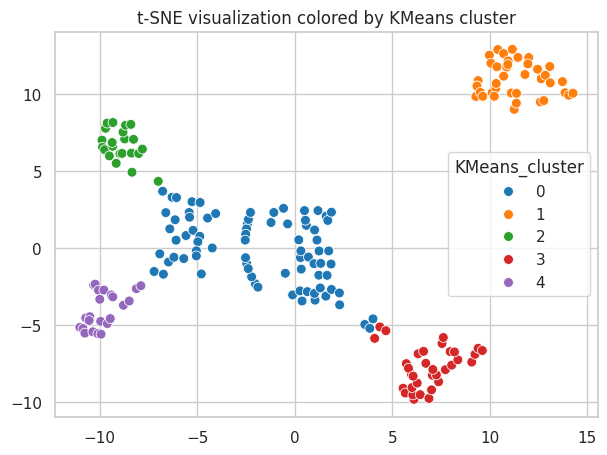

In [20]:
# t-SNE (slower but great for visualization)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_2d)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df_proc['KMeans_cluster'], palette='tab10', s=50, legend='full')
plt.title('t-SNE visualization colored by KMeans cluster'); plt.show()


In [22]:
# Save augmented CSV
out_csv = '/content/Mall_Customers_clustered.csv'
df_proc.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# Save model (pickle)
import joblib
joblib.dump(kmeans, '/content/kmeans_model.pkl')
print("KMeans saved as /content/kmeans_model.pkl")


Saved: /content/Mall_Customers_clustered.csv
KMeans saved as /content/kmeans_model.pkl
